<div style="border-bottom:2px solid black; max-width:450px;">
    <h1 >Chessbot with Computer Vision</h1>
</div>

<img src="./images/logo.png" style="width:150px;margin:0 auto;padding:20px 0 20px 0;"/>

<p> En este breve notebook mostraremos el funcionamiento por partes de manera simple e interactiva de nuestro bot de ajedrez basado en visión por computador.<br>Para ilustrar adecuadamente y de forma  amena y comprensible las entrañas del programa dividiremos la explicación en los siguientes apartados:</p>
<ol>
    <li> Captura de pantalla</li>
  <li>Reconocimiento del tablero</li>
  <li>Análisis del mejor movimiento</li>
  <li>Movimiento automático por ordenador</li>
</ol>

<p>Todo el código puede encontrarse en el siguiente enlace <a href="https://github.com/Blackwolf4183/ChessBot_ComputerVision"> en github </a> completo y con su documentación.</p>

<h2 style=""><b>0. Prompt al usuario</b></h2>

<p> Un paso 0, muy trivial pero esencial para nuestro analizador, es preguntar al usuario con que piezas va a jugar la partida (blancas o negras), ya que es imposible determinar, dado una configuración aleatoria de tablero sin esta información, que piezas estamos jugando.</p>
<p> Para este paso hemos usado la libreria <a href="https://pypi.org/project/PyQt5/"><b>Pyqt5</b></a> la cual nos permite crear interfaces de usuario gráficas (GUI) que interactuen con nuestro código. </p>

<img src="images/ChessBot_GUI.png" style="width: 400px;margin: 0 auto"/>


<h2 id="#1"><b>1. Captura de pantalla</b></h2>


<p> El primer paso que debemos realizar si queremos que nuestro bot juegue al ajedrez de forma autónoma es alguna forma de darle información primitiva, que en este caso serán capturas de lo que estamos viendo en el ordenador y con ello procesar las imágenes y transformarlas en información útil. <br> Para realizar este paso usaremos la API de windows, la cual podemos acceder a través de la libreria pywin32 y la cual nos permitirá tomar capturas de pantalla, pero también identificar las ventanas activas y maximizarlas o minimizarlas. <br> Dicho esto, el proceso que realizamos en este apartado es el siguiente: </p>

<ol>
  <li>Obtendremos una lista de las ventanas abiertas</li>
    <li>Comprobamos que <a href="www.Chess.com">Chess.com </a> esté abierto en alguna de ellas y no en más de una, puesto que de lo contrario no estaríamos jugando una partida</li>
  <li>Una vez localizada la venta procedemos primero a minimizarla y luego a maximizarla para tenerla en pantalla completa</li>
  <li>Finalmente comienza el bucle en el que se va tomando esporádicamente una captura de lo que hay en pantalla y toca procesarla</li>
</ol>



<h2 style=""><b>2. Reconocimiento del tablero</b></h2>

<p> Este es uno de los pasos esenciales de nuestra aplicación. A través de distintos métodos y algoritmos y con ayuda de la librería <b>opencv</b> conseguiremos analizar una imagen que contenga un tablero de la pagina de <a href="https://www.Chess.com"> Chess.com </a>y "virtualizar" la información que vemos por pantalla a otra que podamos manejar nosotros para posteriormente proceder al calculo de las jugadas.</p> 

<p> Para transmitir de forma sencilla el funcionamiento del programa analizaremos uno por uno los métodos más importantes que nos van a ir permitiendo procesar la imagen. </p>

<h2> Paso 1 </h2>

<p> Todas las imagenes que recopila nuestra capturadora del <a hfref="#id">apartado 1</a> pasan por la clase <b> ChessboardAnalizer </b>, la cual se encarga en primer lugar de localizar de forma precisa el tablero en la pantalla. </p>

<img src="images/CapturaRaw.png" style="width:600px"/>

<p> Supongamos que la imagen de arriba es una captura cualquiera de una partida de ajedrez, observamos que hay mucha información que no necesitamos (basicamente todo aquello que no sea el tablero), por lo que nuestro objetivo será recortar la imagen para acabar solo con  el tablero, el cual contiene la información relevante. Nuestra aproximación a este problema es la siguiente:</p>

In [33]:
import cv2 as cv
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib
import imutils
import io
import chess
import chess.svg
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)


In [34]:
def getContours(board_image):

        #Convertir a escala de grises la imagen
        gray = cv.cvtColor(board_image, cv.COLOR_BGR2GRAY)
        #Calculamos el threshold adaptativo
        th = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,9,2)       
        
        #Printeamos la imagen
        plt.subplot(2,2,1)
        plt.title("Image con Threshold")
        plt.imshow(cv.cvtColor(th, cv.COLOR_BGR2RGB))
        
        #Encontramos los contornos de la imagen
        contours, _ = cv.findContours(th, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
        return contours

<p> Esta primera función se encarga de extraer los contornos de la imagen. La idea es ver todos los posibles contornos cerrados en la imagen, y aquel con mayor perímetro y con forma cuadrada debe ser el de nuestro tablero. Por ello, primero pasamos la imagen a gris y posteriormente aplicamos un threshold adaptativo que diferencie perfectamente cada cuadrado para posteriormente aplicar la funcion <b>findContours</b>. </p>

In [35]:
def findBoard(board_image,contours):
        #Suma máxima del tamaño de los contornos (width + height)
        maxSum = 0
        #Aquí almacenamos el contorno más grande en perímetro/2
        contornoMax = []
        #Variables para luego cropear la imagen
        xSquare, ySquare, wSquare, hSquare = 0, 0, 0, 0
        #Iteramos los contornos
        for cnt in contours:
            approx = cv.approxPolyDP(cnt, 0.05 * cv.arcLength(cnt, True), True)
            if len(approx) == 4:
                x, y, w, h = cv.boundingRect(cnt)
                ratio = float(w) / h
                
                if w + h > maxSum and 0.9 <= ratio <= 1.1:  # Buscamos el cuadrado mas grande con la suma de ancho y alto
                    maxSum = w + h
                    contornoMax = cnt
                    xSquare, ySquare, wSquare, hSquare = x, y, w, h  # Guardamos el cuadrado para recortar

        # Recorte de la imagen
        cropped_chessboard = board_image[ySquare+5:ySquare + hSquare -5,
                                        xSquare+5:xSquare +
                                        wSquare - 5]  
        #Dibujamos el contorno detectado
        board_image = cv.drawContours(board_image, [contornoMax], -1, (0, 255, 0), 3)
        
        return cropped_chessboard

<p> Una vez tenemos todos los contornos en un array podemos empezar a iterar entre ellos y ver cuantos de ellos tienen 4 lados y el ratio entre la altura y el ancho los hace aproximadamente un cuadrado. Con aquellos contornos que pasan este filtro tratamos de encontrar el que tiene el perímetro máximo y finalmente con aquel que tiene el perímetro máximo podemos extraer su posición y usarla para recortar la imagen inicial y obtener únicamente el tablero.</p>

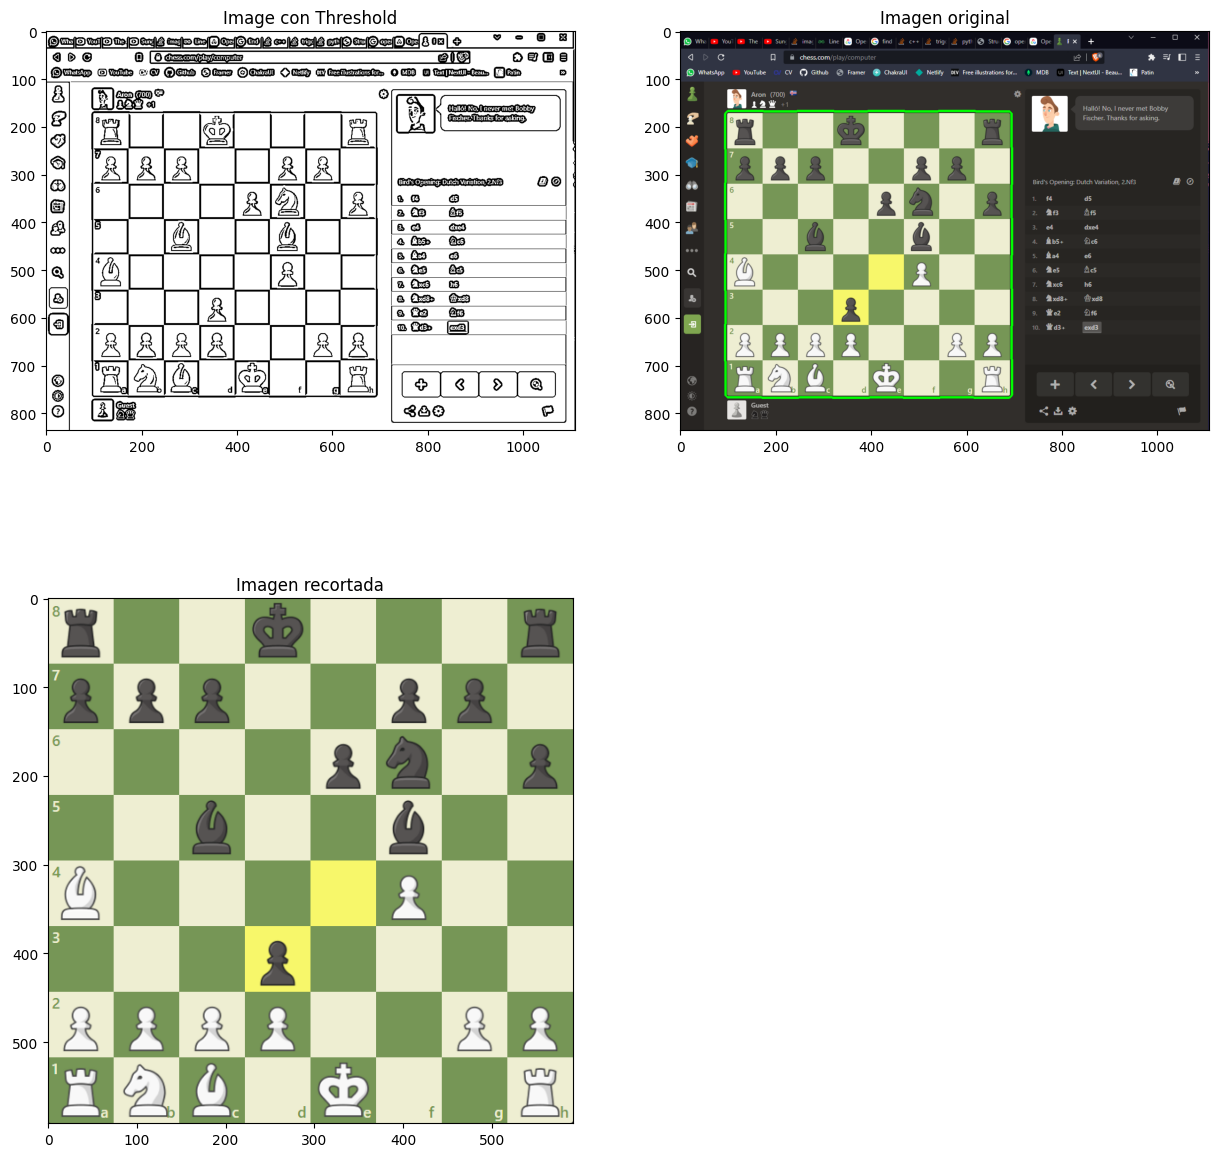

In [36]:
image_raw = cv.imread('images/CapturaRaw.png',cv.IMREAD_UNCHANGED)

contours = getContours(image_raw)
cropped_board = findBoard(image_raw,contours)

plt.subplot(2,2,2)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(image_raw, cv.COLOR_BGR2RGB))

plt.subplot(2,2,3)
plt.title("Imagen recortada")
plt.imshow(cv.cvtColor(cropped_board, cv.COLOR_BGR2RGB))


<p> ¡Ahí la tenemos! Como vemos nuestro algoritmo consigue detectar y recortar sin ningún problema el tablero. Esto nos facilita en gran medida el reconocimiento de piezas que ahora veremos. </p>
<p> Es importante remarcar que este no es la primera ocurrencia que tuvimos para resolver este problema, probamos anteriormente a aplicar otros algoritmos como <b>Hough</b> o <b>NCC</b>, sin embargo, estos no resultaron adecuados para esta aplicación y no daban buenos resultados. La actual implementación utiliza el algoritmo de contornos de Suzuki, proporcionado por opencv, para el cual se puede encontrar una detalla explicación <a href="https://pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/">aquí</a>. </p>

<h2> Paso 2 </h2>

<p> En este paso nuestro objetivo será identificar todas las piezas presentes, así como los espacios vacíos para poder virtualizar correctamente el tablero. </p>
<p> Nuestra primera aproximación a este problema fue usar NCC directamente aplicado al tablero entero con las imagenes de las distintas piezas recortadas para ver donde se localizaban los puntos máximos y así conseguir hacer una correspondencia. </p>

<img src="images/NCCPeones1.jpeg" style="width:300px; "/>

<img src="images/NCCPeones2.jpeg" style="width:600px;"/>

<p> En la imagen de arriba hemos puesto una prueba que realizamos intentando detectar los peones, y se puede observar que aperecen puntos blancos (valores máximos) en los lugares donde deberían estar los peones en la configuración inicial del tablero. Sin embargo, esta método hacia muy dificil distinguir si no habia ninguna pieza (ya que siempre ibamos a encontrar un valor máximo por muy "pequeño" que fuese) y además era poco precisa la predicción del tipo de pieza de esta forma. </p>

<p> Finalmente optamos por usar NCC pero fue necesario hacerlo invariante a escala, debido a que en función a la resolución de pantalla, el template fijo que usabamos no detectaba bien las piezas con distintos tamaños de tablero. </p>

<p> Para no hacer la explicación muy extensa lo mejor será ir paso a paso explicando cada una de las funciones del código. </p>

In [37]:
def divideSquares(cropped_board):

        img_width = cropped_board.shape[0] #Anchura del tablero
        square_size = int(img_width / 8)  # Tamaño del lado del cuadrado

        squares_arr = [] #Array que contenga las posiciones de arriba izquierda de los cuadrados

        #Añadimos las posiciones en la pantalla de los cuadrados
        for f in range(8):
            for c in range(8):
                squares_arr.append(
                    (int(f * square_size), int(c * square_size)))

        return squares_arr, square_size

<p> En primer lugar dividimos nuestro tablero en 64 cuadrados con la función <b> divideSquares() </b>, la cual nos devuelve el tamaño y posiciones, en la imagen del tablero, de cada una de las celdas.</p>

In [38]:
squares_arr, square_size = divideSquares(cropped_board)
print("Array de celdas: ", squares_arr)
print("Tamaño de la celda: ", square_size , " pixeles")

Array de celdas:  [(0, 0), (0, 74), (0, 148), (0, 222), (0, 296), (0, 370), (0, 444), (0, 518), (74, 0), (74, 74), (74, 148), (74, 222), (74, 296), (74, 370), (74, 444), (74, 518), (148, 0), (148, 74), (148, 148), (148, 222), (148, 296), (148, 370), (148, 444), (148, 518), (222, 0), (222, 74), (222, 148), (222, 222), (222, 296), (222, 370), (222, 444), (222, 518), (296, 0), (296, 74), (296, 148), (296, 222), (296, 296), (296, 370), (296, 444), (296, 518), (370, 0), (370, 74), (370, 148), (370, 222), (370, 296), (370, 370), (370, 444), (370, 518), (444, 0), (444, 74), (444, 148), (444, 222), (444, 296), (444, 370), (444, 444), (444, 518), (518, 0), (518, 74), (518, 148), (518, 222), (518, 296), (518, 370), (518, 444), (518, 518)]
Tamaño de la celda:  74  pixeles


<p> Teniendo en memoria las posiciones de las 64 celdas nuestra idea fue la siguiente; podemos ir iterando por todas las celdas del tablero y mirar con los distintos templates que tenemos de las piezas a ver cual de estos nos da la mejor correspondencia y asignar así a la celda la pieza que nos diese el mayor valor NCC. </p>
<p> Sin embargo hay que añadir algunos elementos a esta idea para que resulte efectiva: </p>

<ol>
    <li> Detectar primero si el cuadrado está vacío </li>    
    <li> Añadir invarianza a escala a la función <b>matchTemplate()</b> de opencv </li>
    <li> Distinguir si la pieza es negra o blanca </li>
</ol>

<h3> Detectar cuadrados vacios </h3>

In [39]:
def isBlankSquare(square):

    image = cv.cvtColor(square,cv.COLOR_BGR2RGB)

    flattened_img = image.reshape((-1,3))
    result = np.unique(flattened_img, axis=0, return_counts = True)
    image_size = len(flattened_img)
    ocurrences = result[1]
    max_ocurrence = np.amax(ocurrences)

    return max_ocurrence/image_size > 0.8

<p> Como indica el nombre de la función, esta se encarga de detectar si una celda está vacía. Para ello simplemente crea un diccionario de todos los posibles colores en la imagen (combinaciones RGB) y calcula su frecuencia. Tras calcular este "histograma", concluimos en que si hay un tipo de color que represente a más del 80% de los pixeles de la imagen, entonces nos encontramos ante una celda sin pieza. Este umbral es importante definirlo ya que pueden existir celdas con números o algunas indicaciones propias del juego que no la hagan perfectamente uniforme. </p>

isBlankSquare(test_square1):  False
isBlankSquare(test_square2):  True


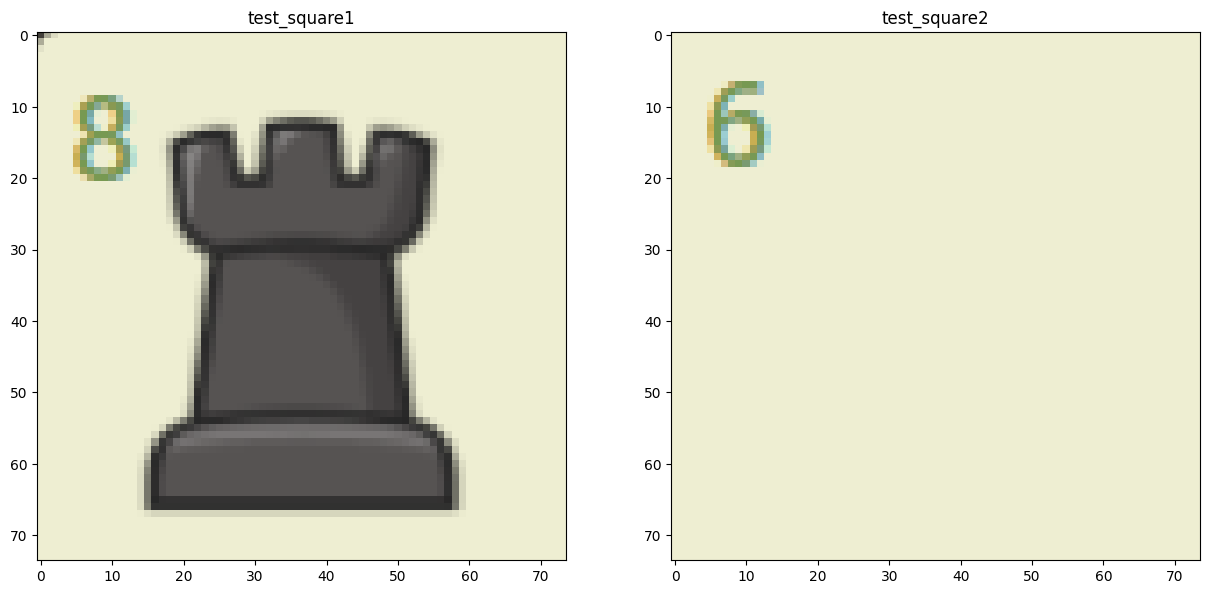

In [40]:
#Tomamos 3 cuadrados de referencia distintos
test_square1 = cropped_board[square_size*0:square_size*0+square_size,square_size*0:square_size*0+square_size]
test_square2 = cropped_board[square_size*2:square_size*2+square_size,square_size*0:square_size*0+square_size]
test_square3 = cropped_board[square_size*7:square_size*7+square_size,square_size*0:square_size*0+square_size]

plt.subplot(1,2,1)
plt.title("test_square1")
plt.imshow(cv.cvtColor(test_square1, cv.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title("test_square2")
plt.imshow(cv.cvtColor(test_square2, cv.COLOR_BGR2RGB))

print("isBlankSquare(test_square1): ", isBlankSquare(test_square1))
print("isBlankSquare(test_square2): ", isBlankSquare(test_square2))

<p> Con esto eliminamos también buena parte del tiempo de ejecución que necesitará nuestro método personalizado de matchTemplate(), al descartar muy rapidamente buena parte de los cuadrados.</p> 

<h3> Invarianza a escala para matchTemplate()</h3>

<p> Comencemos primero explicando como detectamos que pieza hay en cada celda. En primer lugar, para hacer los matches más sencillos no utilizamos una imagen normal, si no que primero aplicamos Canny para extraer la información de los bordes, y así posteriormente "comparar" la imagen con unos templates personalizados a los que también previamente hemos aplicado Canny, resultando en los siguientes: </p>


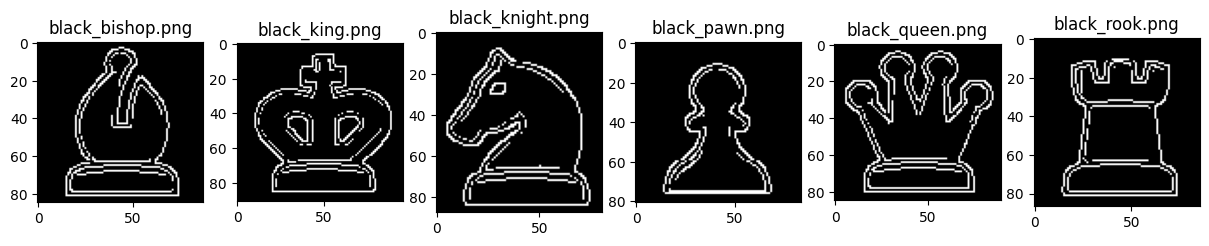

In [41]:
directory = "images/template_images"

column = 1

for filename in os.listdir(directory):
    template = cv.imread(directory + "/" + filename,cv.IMREAD_UNCHANGED)
    plt.subplot(1,6,column)
    plt.title(filename)
    plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
    column += 1

<p> Realmente solo necesitamos 6 templates, porque las figuras son practicamente idénticas al realizar Canny con ambos colores, además de esta forma solo comparamos 6 veces en lugar de 12, a coste de posteriormente tener que identificar el color de cada pieza (pero esta operación no es ni mucho menos tan costosa).</p>

<p> Al probar estos templates nos encontramos con el siguiente problema; en diferentes resoluciones de pantalla o con la ventana del navegador en tamaños pequeños los matches son muy malos. Esto se debe a que el método matchTemplate no es invariante a escala, por lo que para solucionarlo ideamos la siguiente función:</p>

In [42]:
def getBestScaleMatch(original,template):
            
    (tH, tW) = template.shape[:2]

    found = None
    bestMatch = 0.0

    for scale in np.linspace(0.2, 1.6, 20)[::-1]:
        #reescalamos la imagen original
        resized = imutils.resize(original, width = int(original.shape[1] * scale))
        #calculamos ratio
        r = original.shape[1] / float(resized.shape[1])

        #Si el template es más grande que la imagen cambiada de tamaño no nos sirve
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        #Aplicamos Canny a la imagen original
        original_edged = cv.Canny(resized,100,200)
        result = cv.matchTemplate(original_edged, template, cv.TM_CCORR_NORMED) 
        _, maxVal, _, maxLoc = cv.minMaxLoc(result) #Precision

        #Maximización de los resultados
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)

        if maxVal > bestMatch:
            bestMatch = maxVal

    return bestMatch

<p> Esta función lo que hace es escalar la imagen original en distintas dimensiones y compararla con una plantilla para ver si obtenemos un mejor match al variarla ya que nuestras imagenes no siempre van a tener las mismas dimensiones que aquellas que vengan del tablero que estamos capturando. </p>

<p> Veamos un pequeño ejemplo de su funcionamiento: </p>

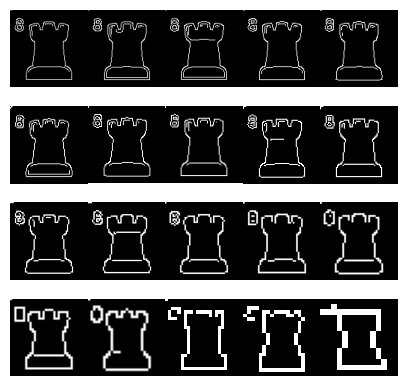

In [43]:
c = 1

for scale in np.linspace(0.2, 1.6, 20)[::-1]:
    #reescalamos la imagen original
    resized = imutils.resize(test_square1, width = int(test_square1.shape[1] * scale))
    original_edged = cv.Canny(resized,100,200)
    plt.subplot(4,5,c)
    plt.axis('off')
    plt.imshow(original_edged, cmap="gray")
    plt.gcf().set_size_inches(5, 5)
    c += 1
        
plt.subplots_adjust(wspace=0, hspace=0)

<p> Esta sería el escalado de la <b>imagen original</b> que le proporcionamos a la función y que utiliza para intentar asemejarse lo máximo posible a la <b>plantilla</b>.</p>

<h3> Distinguir entre piezas blancas o negras </h3>

<p> Por último, si hemos detectado una pieza, nos queda la duda de si esta es blanca o negra, por lo que necesitamos de una función que nos diga el color de esta:</p>

In [44]:
def isPieceWhite(cropped_square):
    s_window = 5
    #Pasamos a gris
    cropped_square = cv.cvtColor(cropped_square,cv.COLOR_BGR2GRAY)
    
    w = cropped_square.shape[0]
    h = cropped_square.shape[1]
    center = (int(w/2),int(h/2))
    #Cogemos una unica ventana en el centro de la imagen que es donde va a estar la pieza
    _, binarized_square = cv.threshold(cropped_square,127,255,cv.THRESH_BINARY)
    cropped_square = binarized_square[center[1]+int(h/3.5):center[1]+int(h/3),center[0]-s_window:center[0]+s_window]


    whitePixels = 0
    flattened_img = np.array(cropped_square).flatten()
    for pixel in flattened_img:
        #100 es el threshold de intensidad para considerar pixel blanco
        if pixel > 100: whitePixels = whitePixels +1

    #Si hay una proporcion grande de pixeles blancos (la ventana quizas se ha desplazado hacia un borde un poco)
    return whitePixels > int(flattened_img.shape[0]/1.5)

<p> La función puede parecer más complicada de lo que es, pero en realidad lo que hace es mirar una pequeña ventana por el centro de la imagen (la cual previamente ha binarizado) y cuenta la cantidad de pixeles blancos y negros. Si finalmente la mayor parte de los píxeles contados son blancos, la pieza resultante es blanca y de igual forma con las piezas negras. Podría haberse hecho mirando un unico pixel binarizado de la imagen pero como cada pieza es distinta en forma es posible que ese pixel no estuviese siempre dentro de la pieza, por ello es la razón de usar una ventana pequeña. </p>

isPieceWhite(test_square1):  False
isPieceWhite(test_square3):  True


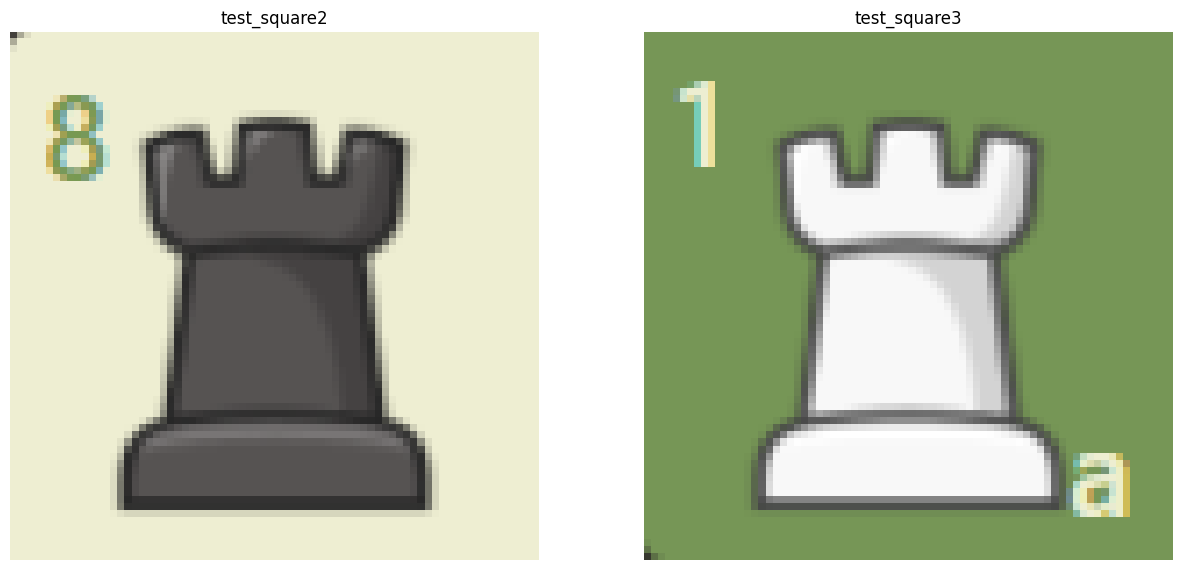

In [45]:

print("isPieceWhite(test_square1): ", isPieceWhite(test_square1))
print("isPieceWhite(test_square3): ", isPieceWhite(test_square3))

plt.subplot(1,2,1)
plt.axis('off')
plt.title("test_square2")
plt.imshow(cv.cvtColor(test_square1, cv.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.axis('off')
plt.title("test_square3")
plt.imshow(cv.cvtColor(test_square3, cv.COLOR_BGR2RGB))


<h3> ¡Toca juntarlo todo! </h3>

<p> Ya tenemos los métodos esenciales para detectar las piezas del tablero solo falta juntarlo todo y ver los resultados. </p>
<p> Por medio añadiremos un par de funciones, una que nos convertirá el resultado del tablero virtualizado en la notación <b> FEN </b> ampliamente utilizada en el ajedrez para describir configuraciones de tableros, y otra para imprimir por pantalla un array bidimensional.</p>

In [46]:
def array2fen(chess_array):
    # StringIO es mas eficiente para concatenar
    with io.StringIO() as s:
        for row in range(8):
            empty = 0
            for cell in range(8):
                c = chess_array[row][cell]
                if c != 0:
                    if empty > 0:
                        s.write(str(empty))
                        empty = 0
                    #escribir en notación FEN la pieza
                    s.write(index2piece[abs(c)].upper(
                    ) if c > 0 else index2piece[abs(c)].lower())
                else:
                    empty += 1
            if empty > 0:
                s.write(str(empty))
            s.write('/')
        # Move one position back to overwrite last '/'
        s.seek(s.tell() - 1)
        s.write(' w KQkq - 0 1')
        return s.getvalue()

In [47]:
def printArrayBoard(chess_array):
    for f in range(8):
        print("")
        for c in range(8):
            if(chess_array[f,c] < 0):
                print(chess_array[f,c], "|",end = '')
            else: 
                print(chess_array[f,c], " |",end = '')
    print("")


In [48]:
#Conversión de nombres de ficheros a códigos de piezas
filename2piece = {
        "images/template_images\\black_pawn.png": -1,
        "images/template_images\\black_knight.png": -2,
        "images/template_images\\black_bishop.png": -3,
        "images/template_images\\black_rook.png": -4,
        "images/template_images\\black_queen.png": -5,
        "images/template_images\\black_king.png": -6,
    }

#Conversión de código de pieza a notación FEN
index2piece = {
    1: "p",
    2: "n",
    3: "b",
    4: "r",
    5: "q",
    6: "k",
}

In [49]:
def classifyPieces( squares_array, square_size, cropped_chessboard):

        #Iteramos por todos los cuadrados y vamos añadiendo piezas
        directory = 'images/template_images'
        #Valores 
        precision_values = []
        board = np.zeros((8,8), dtype=np.int64)

        for (x, y) in squares_array:
            #Cropeamos las imagenes
            chess_square = cropped_chessboard[x:x + square_size,y:y + square_size]

            #Filtramos primero si es un cuadrado vacío
            if isBlankSquare(chess_square):
                #Si no tiene nada continuamos a la siguiente iteración 
                continue 

            for filename in os.listdir(directory):
                f = os.path.join(directory, filename)
                # Si es un archivo
                if os.path.isfile(f):
                    current_img = cv.imread(f, 0)
                    best_match = getBestScaleMatch(chess_square,current_img)
                    precision_values.append((f, best_match))
               
            #print(precision_values)

            top_piece = "",
            top_value = -math.inf

            for (name, precision) in precision_values:
                if precision > top_value:
                    top_value = precision
                    top_piece = name

            #posicionamiento en tablero virtual
            x_piece = int(x / int(square_size))
            y_piece = int(y / int(square_size))
            

            piece_value = filename2piece[top_piece]

            #Evaluamos si la pieza es blanca para cambiarle el valor
            if(isPieceWhite(chess_square)):
                piece_value = -piece_value

            #Metemos la pieza en la matriz
            board[x_piece][y_piece] =  piece_value

            #Vaciamos array
            precision_values.clear()

        # Creación de string para notación FEN
        fen = array2fen(board)

        return board, fen

<p> Recordemos una vez más el tablero inicial del que partiamos:</p>

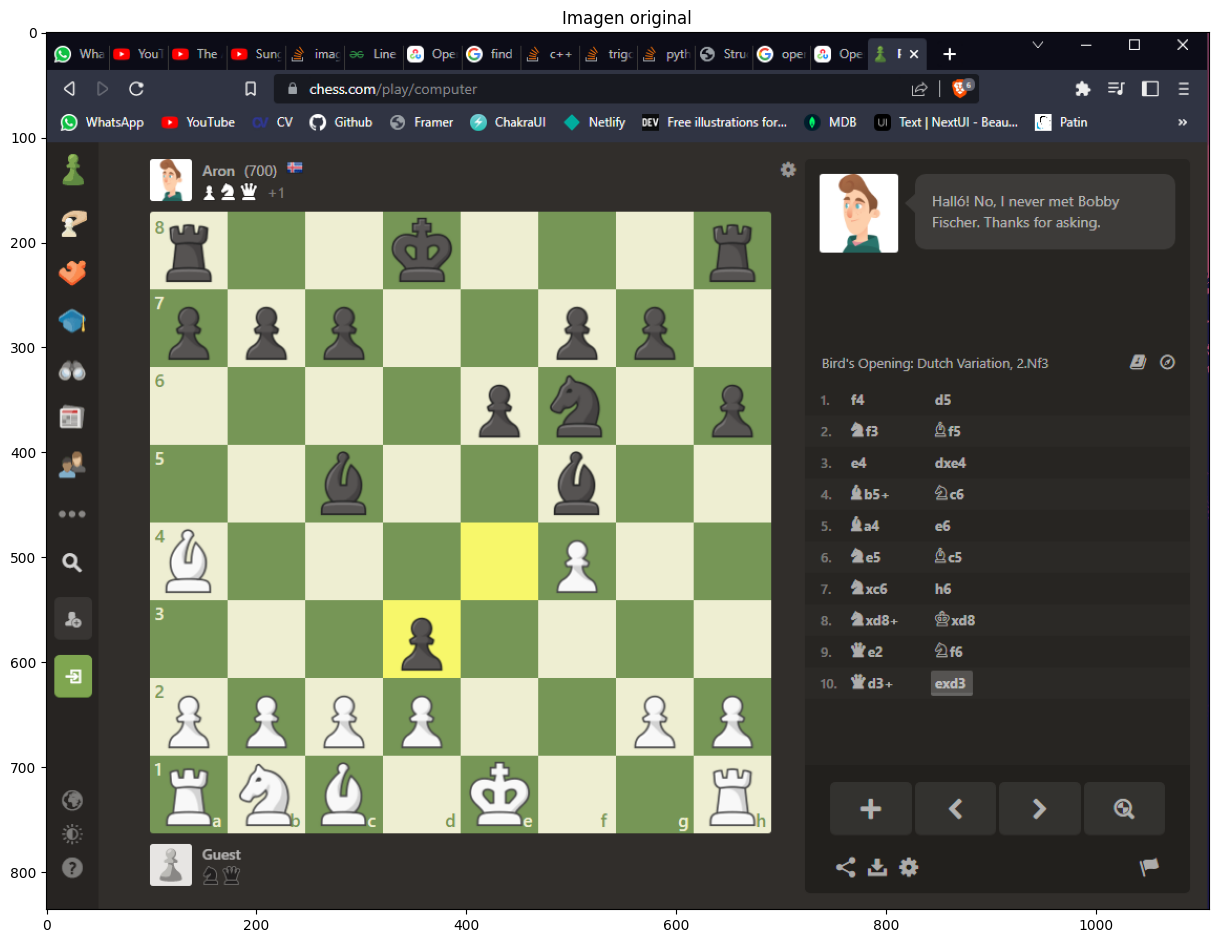

In [50]:
imagen_inicial = cv.imread('images/CapturaRaw.png',cv.IMREAD_UNCHANGED)

plt.subplot(1,1,1)
plt.title("Imagen original")
plt.imshow(cv.cvtColor(imagen_inicial, cv.COLOR_BGR2RGB))

<p> Y lo que conseguimos obtener a partir de ella </p>

In [51]:
board, fen = classifyPieces(squares_arr, square_size,cropped_board)
printArrayBoard(board)
print("")
print("Tablero en notación FEN: ", fen)


-4 |0  |0  |-6 |0  |0  |0  |-4 |
-1 |-1 |-1 |0  |0  |-1 |-1 |0  |
0  |0  |0  |0  |-1 |-2 |0  |-1 |
0  |0  |-3 |0  |0  |-3 |0  |0  |
3  |0  |0  |0  |0  |1  |0  |0  |
0  |0  |0  |-1 |0  |0  |0  |0  |
1  |1  |1  |1  |0  |0  |1  |1  |
4  |2  |3  |0  |6  |0  |0  |4  |

Tablero en notación FEN:  r2k3r/ppp2pp1/4pn1p/2b2b2/B4P2/3p4/PPPP2PP/RNB1K2R w KQkq - 0 1


<p> Incluso teniendo la notación FEN y una librería de utilidades de ajedrez para Python podemos renderizar la siguiente imagen:</p>

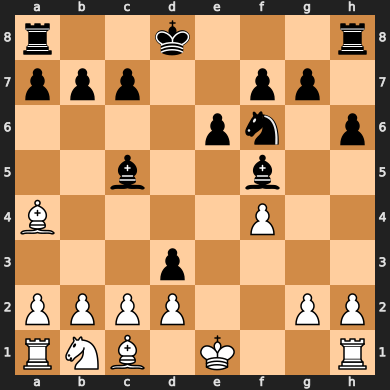

In [53]:
board = chess.Board(fen)
board

<p> ¡Genial! En principio hemos sido capaces de obtener todas las posiciones y piezas correctamente a través de únicamente una captura de nuestra pantalla completa. Ahora damos paso a la siguiente parte de esta libreta, el motor de ajedrez que nos permitirá decidir los mejores movimientos. </p>

<h2 style=""><b>3. Análisis del mejor movimiento</b></h2>

Esto lo escribes tu maquinon